# Vote Prediction in the Brazilian Congress: Baseline Evaluation

This notebook presents an evaluation of baseline models for predicting voting outcomes in the Brazilian National Congress. The goal is to explore and assess different approaches for vote prediction, focusing on two distinct tasks:

1. **Global Prediction**: Predicting whether a legislative proposal will be approved or rejected, based on available contextual and historical data.
2. **Deputy-level Prediction**: Predicting how each deputy will vote (Yes, No, Abstain, etc.) on each legislative proposal.

To evaluate the performance of the baseline models, we rely on the following metrics:

- **Accuracy**
- **F1 Score**
- **Precision**
- **Recall**
- **Area Under the ROC Curve (AUROC)**

To ensure a structured and repeatable process, we adopt a methodology inspired by the **CRISP-DM** framework (Cross-Industry Standard Process for Data Mining). The analysis will follow the steps below:

1. **Business Understanding**: Define the objectives and relevance of vote prediction in the legislative context.
2. **Data Understanding**: Explore the datasets related to congressional voting, including deputies, proposals, and vote records.
3. **Data Preparation**: Clean, integrate, and transform the data for modeling purposes.
4. **Modeling**: Implement and evaluate baseline models for both prediction tasks.
5. **Evaluation**: Compare model results using the selected metrics to understand predictive performance.
6. **Deployment (Optional)**: Discuss potential applications and future steps based on the findings.

This notebook focuses on steps 3 to 5, with a strong emphasis on establishing robust baselines for future improvements.

## Baseline Models for Global Prediction

To establish reference points for evaluating the performance of more complex models, we begin with a set of simple baseline approaches for the global prediction task — that is, predicting whether a legislative proposal will be **approved** or **rejected**.

These baselines do not rely on advanced learning algorithms and serve to highlight the minimum performance a real model should exceed.

### 1. Random Guess

This baseline randomly assigns each proposal a label of "approved" or "rejected" with equal probability (i.e., 50/50 chance). It represents a naive classifier with no information about the proposal or historical data.

### 2. Majority Class

This model always predicts the most frequent class found in the training dataset. If most proposals in the training data were approved, it will always predict approval.

This baseline is important for understanding whether a model is just mimicking class imbalance or actually learning meaningful patterns.

### 3. Stratified Probability

This baseline predicts "approval" with the same probability as the overall approval rate found in the training data. For instance, if 70% of proposals in the training set were approved, this model will randomly assign "approval" with a 70% chance and "rejection" with a 30% chance.

This approach introduces a minimal level of probabilistic modeling based on class distribution.

### 4. Simple Heuristic (Government Recommendation)

This heuristic assumes that if the government recommends a **"yes"** vote on a proposal, it is likely to be approved. The prediction rule is as follows:

- If the government's vote recommendation is **"yes"**, predict **approval**.
- Otherwise, predict **rejection**.

This baseline leverages external political signals and serves as a weak domain-informed heuristic for comparison.

---

Each of these baselines will be evaluated using the following metrics:

- **Accuracy**
- **F1 Score**
- **Precision**
- **Recall**
- **AUROC**

These baselines provide essential context for interpreting the performance of more sophisticated models in future experiments.

## Baseline Models for Deputy-level Prediction

In this section, we define baseline strategies for predicting how **each individual deputy** will vote on a given proposal. These baselines serve as simple reference points for evaluating the performance of more sophisticated models that may incorporate legislative context, political alignment, or voting history.

### 1. Random Guess

Each deputy casts a vote selected randomly from the set of possible options (e.g., "Yes", "No", "Abstain", "Obstruct"). This model does not use any historical or contextual information and serves as a lower-bound benchmark.

### 2. Personalized Random Guess

Instead of drawing votes with uniform probability, this model uses the **empirical vote distribution of each deputy**. For example, if a deputy historically votes "Yes" in 70% of cases, this model assigns "Yes" with 70% probability, and so on for the other options.

This approach reflects the individual voting tendencies of each deputy while still relying on random selection.

### 3. Party Voter (Partisan Baseline)

In this baseline, the deputy is assumed to follow the **official party recommendation** for each vote. If the party's orientation is "Yes", the model predicts that the deputy will vote "Yes".

This strategy assumes party discipline and is useful to evaluate how much better a model performs compared to a rule-based party alignment.

### 4. Sponsor Biased Voter

This heuristic uses the **author of the proposal** as a predictor of deputy behavior. Deputies may have a bias in favor or against certain authors or parties.

For this baseline, we compute how each deputy historically votes when a proposal is authored by certain groups (e.g., by the government, their own party, or specific individuals). The model then predicts a vote based on the observed historical trend for similar authorship cases.

---

These baselines will be evaluated using the following metrics:

- **Accuracy**
- **F1 Score**
- **Precision**
- **Recall**
- **Area Under the ROC Curve (AUROC)**

By comparing more complex models to these baselines, we can assess whether they capture meaningful patterns beyond simple heuristics or random behavior.


In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import random
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# For models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [3]:
# Load the data
df_votacoes = pd.read_csv('Global Vote Prediction Table/votacoes_network.csv')

# Display the first few rows to understand the structure
print("Dataset shape:", df_votacoes.shape)
df_votacoes.head()


Dataset shape: (43399, 14)


,id,idDeputadoAutor,legislatura,data,tema,classified_llm,authors_pop,authors_major_comm,orientacao_GOV,aprovacao,autor_eigenvector_centrality,autor_clustering_coefficient,autor_pagerank,autor_community_id
0,340896-3,74399,53,2007-02-14,Defesa e Segurança,Approval of Requests,0.0,0,Neutro,1,0.007723,0.066571,0.000909,1
1,340896-3,74399,53,2007-02-14,Direito Penal e Processual Penal,Approval of Requests,0.0,0,Neutro,1,0.007723,0.066571,0.000909,1
2,340368-20,74517,53,2007-02-15,"Política, Partidos e Eleições",Change in Processing Regime,0.0,1,Neutro,1,0.043880,0.357156,0.001855,0
3,340368-21,74399,53,2007-02-15,"Política, Partidos e Eleições",Approval of Requests,0.0,0,Neutro,1,0.007723,0.066571,0.000909,1
4,340368-31,74324,53,2007-02-15,"Política, Partidos e Eleições",Approval of Final Wording,0.0,0,Neutro,1,0.039475,0.280483,0.001889,1


Distribution of approval status:
aprovacao
1    69.771193
0    30.228807
Name: proportion, dtype: float64


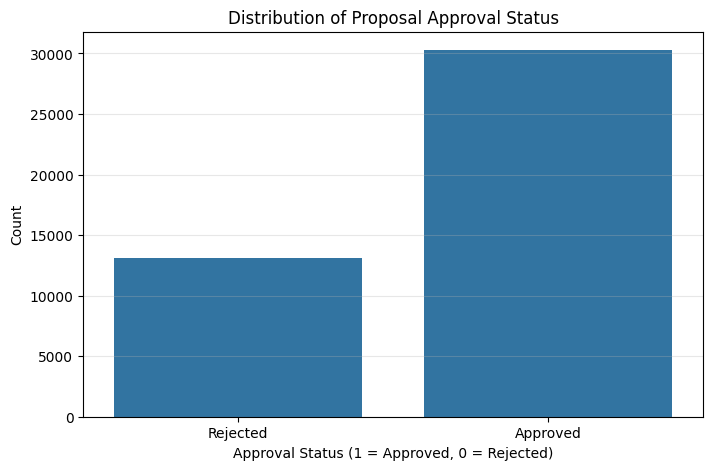


Missing values in each column:
id                              0
idDeputadoAutor                 0
legislatura                     0
data                            0
tema                            0
classified_llm                  0
authors_pop                     0
authors_major_comm              0
orientacao_GOV                  0
aprovacao                       0
autor_eigenvector_centrality    0
autor_clustering_coefficient    0
autor_pagerank                  0
autor_community_id              0
dtype: int64


In [4]:
# Explore the target variable (approval status)
print("Distribution of approval status:")
approval_counts = df_votacoes['aprovacao'].value_counts(normalize=True) * 100
print(approval_counts)

# Visualize the approval distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='aprovacao', data=df_votacoes)
plt.title('Distribution of Proposal Approval Status')
plt.xlabel('Approval Status (1 = Approved, 0 = Rejected)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Rejected', 'Approved'])
plt.grid(axis='y', alpha=0.3)
plt.show()

# Check for missing values
print("\nMissing values in each column:")
print(df_votacoes.isnull().sum())


In [5]:
# Prepare data for global prediction (proposal approval)
print("Preparing data for global prediction models...")

# Drop rows with missing values in the approval column if any
df_clean = df_votacoes.dropna(subset=['aprovacao'])

# Split the data into training and testing sets (70% train, 30% test)
X = df_clean.drop('aprovacao', axis=1)
y = df_clean['aprovacao'].astype(int)  # Ensure the target is an integer

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Approval rate in training set: {y_train.mean():.4f}")
print(f"Approval rate in testing set: {y_test.mean():.4f}")


Preparing data for global prediction models...
Training set size: 30379
Testing set size: 13020
Approval rate in training set: 0.6977
Approval rate in testing set: 0.6977


In [6]:
# Helper function to evaluate and display results
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Evaluate a model using multiple metrics and print the results.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_pred_proba: Predicted probabilities for the positive class (for ROC AUC)
        model_name: Name of the model for display purposes
    
    Returns:
        dict: Dictionary containing the evaluation metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # ROC AUC score is only calculated if probabilities are provided
    roc_auc = None
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
        except:
            roc_auc = None
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print results
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC:   {roc_auc:.4f}")
    else:
        print("ROC AUC:   N/A")
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Return metrics as dictionary
    results = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }
    
    return results


In [7]:
## 1. Global Prediction Baseline Models
print("Implementing global prediction baseline models...")

# Store results for comparison
global_results = []

# 1. Random Guess
print("\n1. Random Guess Baseline")
np.random.seed(42)  # For reproducibility
random_preds = np.random.randint(0, 2, size=len(y_test))  # Randomly assign 0 or 1
random_probs = np.random.random(size=len(y_test))  # Random probabilities for ROC AUC

random_results = evaluate_model(y_test, random_preds, random_probs, "Random Guess")
global_results.append(random_results)

# 2. Majority Class
print("\n2. Majority Class Baseline")
majority_class = int(y_train.mean() >= 0.5)  # 1 if majority is approved, 0 otherwise
majority_preds = np.full(len(y_test), majority_class)
# For ROC AUC, we'll use a constant probability
majority_probs = np.full(len(y_test), 1.0 if majority_class == 1 else 0.0)

majority_results = evaluate_model(y_test, majority_preds, majority_probs, "Majority Class")
global_results.append(majority_results)

# 3. Stratified Probability
print("\n3. Stratified Probability Baseline")
approval_rate = y_train.mean()
np.random.seed(42)  # Reset seed for reproducibility
stratified_probs = np.random.random(size=len(y_test))  # Generate random numbers
stratified_preds = (stratified_probs < approval_rate).astype(int)  # Convert to binary predictions based on approval rate

stratified_results = evaluate_model(y_test, stratified_preds, stratified_probs, "Stratified Probability")
global_results.append(stratified_results)

# 4. Simple Heuristic (Government Recommendation)
print("\n4. Government Recommendation Heuristic")
# We need to check if 'orientacao_GOV' column exists and is usable
if 'orientacao_GOV' in X_test.columns:
    # Define a mapping for government recommendations
    gov_rec_map = {
        'Sim': 1,  # Yes -> Approve
        'Não': 0,  # No -> Reject
        'Obstrução': 0,  # Obstruction -> Reject
        'Liberado': None,  # Liberated -> No recommendation
        'Neutro': None  # Neutral -> No recommendation
    }
    
    # Apply the mapping
    gov_preds = []
    gov_probs = []
    
    for _, row in X_test.iterrows():
        rec = row['orientacao_GOV']
        if pd.isna(rec) or rec not in gov_rec_map or gov_rec_map[rec] is None:
            # If no clear recommendation, use the approval rate from training data
            pred_prob = approval_rate
            pred = 1 if np.random.random() < approval_rate else 0
        else:
            # Follow the government's recommendation
            pred = gov_rec_map[rec]
            pred_prob = 1.0 if pred == 1 else 0.0
        
        gov_preds.append(pred)
        gov_probs.append(pred_prob)
    
    gov_preds = np.array(gov_preds)
    gov_probs = np.array(gov_probs)
    
    gov_results = evaluate_model(y_test, gov_preds, gov_probs, "Government Recommendation")
    global_results.append(gov_results)
else:
    print("Column 'orientacao_GOV' not found. Skipping Government Recommendation heuristic.")


Implementing global prediction baseline models...

1. Random Guess Baseline

--- Random Guess Evaluation ---
Accuracy:  0.4977
Precision: 0.6952
Recall:    0.4988
F1 Score:  0.5808
ROC AUC:   0.4958

Confusion Matrix:
[[1949 1987]
 [4553 4531]]

2. Majority Class Baseline

--- Majority Class Evaluation ---
Accuracy:  0.6977
Precision: 0.6977
Recall:    1.0000
F1 Score:  0.8219
ROC AUC:   0.5000

Confusion Matrix:
[[   0 3936]
 [   0 9084]]

3. Stratified Probability Baseline

--- Stratified Probability Evaluation ---
Accuracy:  0.5823
Precision: 0.6984
Recall:    0.7062
F1 Score:  0.7023
ROC AUC:   0.5015

Confusion Matrix:
[[1166 2770]
 [2669 6415]]

4. Government Recommendation Heuristic

--- Government Recommendation Evaluation ---
Accuracy:  0.6343
Precision: 0.7400
Recall:    0.7336
F1 Score:  0.7368
ROC AUC:   0.6168

Confusion Matrix:
[[1594 2342]
 [2420 6664]]


In [40]:
# Sort the dataframe by the temporal column "data"
df_sorted = df_votacoes.sort_values('data')

# Determine split index for train and test sets
# Example: 70% train, 30% test
n = len(df_sorted)
train_end = int(0.7 * n)

# Split the data into train and test sets based on "data"
df_train = df_sorted.iloc[:train_end]
df_test = df_sorted.iloc[train_end:]

# Separate features and target, dropping "data" from features
feature_cols = [col for col in df_votacoes.columns if col not in ['aprovacao', 'data', 'idDeputadoAutor', 'id', 'legislatura']]

X_train = df_train[feature_cols]
y_train = df_train['aprovacao']

X_test = df_test[feature_cols]
y_test = df_test['aprovacao']

# Manually specify numerical and categorical columns
numerical_cols = ['authors_pop', 'autor_eigenvector_centrality', 'autor_clustering_coefficient', 'autor_pagerank']
categorical_cols = [col for col in feature_cols if col not in numerical_cols]

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Categorical columns: ['tema', 'classified_llm', 'authors_major_comm', 'orientacao_GOV', 'autor_community_id']
Numerical columns: ['authors_pop', 'autor_eigenvector_centrality', 'autor_clustering_coefficient', 'autor_pagerank']
Training set shape: (30379, 9)
Test set shape: (13020, 9)


In [41]:
# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Dictionary to store results
results = {}

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_matrix


In [43]:
# Preprocessing: Encode categorical features and scale numerical features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit the preprocessor on the training data and transform train and test splits
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after transformation
def get_feature_names(preprocessor):
    feature_names = []
    # Numerical features
    if hasattr(preprocessor.named_transformers_['num'], 'get_feature_names_out'):
        feature_names.extend(preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols))
    else:
        feature_names.extend(numerical_cols)
    # Categorical features
    ohe = preprocessor.named_transformers_['cat']
    if hasattr(ohe, 'get_feature_names_out'):
        feature_names.extend(ohe.get_feature_names_out(categorical_cols))
    else:
        # fallback
        feature_names.extend(categorical_cols)
    return feature_names

processed_feature_names = get_feature_names(preprocessor)

import pandas as pd
X_train_processed = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)

# For model training below, use X_train_processed, X_test_processed

In [44]:
results_df = pd.DataFrame([
    {k: v for k, v in result.items() if k != 'confusion_matrix'} 
    for result in global_results
])

Iniciando busca pelo melhor algoritmo com o melhor F1 score total (usando apenas treino e teste)...

--- Buscando melhores hiperparâmetros para XGBoost ---
Total de combinações: 175
[1/175] Treinando XGBoost com {'n_estimators': 150, 'learning_rate': 0.001, 'max_depth': 3}...
F1 total (macro) no teste: 0.4476
Novo melhor modelo encontrado (maior F1 total no teste)!
[2/175] Treinando XGBoost com {'n_estimators': 150, 'learning_rate': 0.001, 'max_depth': 4}...
F1 total (macro) no teste: 0.4476
[3/175] Treinando XGBoost com {'n_estimators': 150, 'learning_rate': 0.001, 'max_depth': 5}...
F1 total (macro) no teste: 0.4476
[4/175] Treinando XGBoost com {'n_estimators': 150, 'learning_rate': 0.001, 'max_depth': 6}...
F1 total (macro) no teste: 0.4476
[5/175] Treinando XGBoost com {'n_estimators': 150, 'learning_rate': 0.001, 'max_depth': 7}...
F1 total (macro) no teste: 0.4476
[6/175] Treinando XGBoost com {'n_estimators': 150, 'learning_rate': 0.09, 'max_depth': 3}...
F1 total (macro) no te

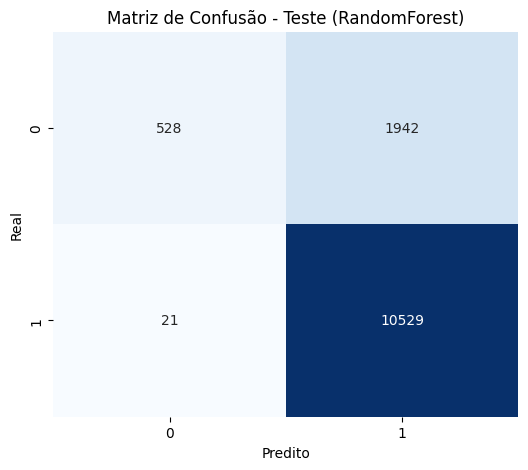

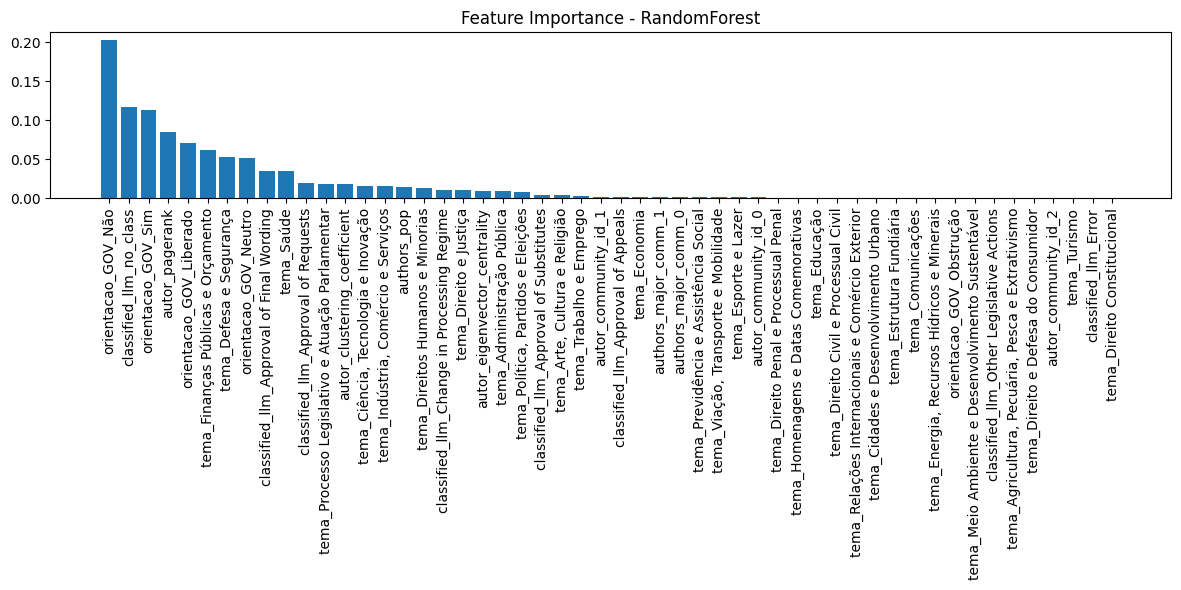


Tabela com os melhores hiperparâmetros de cada algoritmo:
            Algoritmo  Melhor F1 macro teste  \
0             XGBoost               0.623767   
1        RandomForest               0.632257   
2  LogisticRegression               0.587716   

                            Melhores Hiperparâmetros  
0  {'n_estimators': 180, 'learning_rate': 0.1, 'm...  
1              {'n_estimators': 210, 'max_depth': 4}  
2      {'C': 20, 'solver': 'lbfgs', 'max_iter': 200}  

Tabela de resultados dos melhores modelos (atualizada em results_df):
                       model  accuracy  precision    recall        f1  \
0               Random Guess  0.497696   0.695152  0.498789  0.580823   
1             Majority Class  0.697696   0.697696  1.000000  0.821933   
2     Stratified Probability  0.582258   0.698421  0.706187  0.702283   
3  Government Recommendation  0.634255   0.739951  0.733598  0.736761   
4                    XGBoost  0.770968   0.625055  0.622553  0.623767   
5               Ran

In [45]:
# Encontrar o melhor algoritmo com o melhor F1 score total (usando apenas treino e teste)
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("Iniciando busca pelo melhor algoritmo com o melhor F1 score total (usando apenas treino e teste)...")

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Definir grids de parâmetros para cada algoritmo
param_grids = {
    'XGBoost': {
        'n_estimators': [150,160,170,180,190, 200, 210],
        'learning_rate': [0.001, 0.09, 0.1, 0.15, 0.2],
        'max_depth': [3, 4, 5, 6, 7]
    },
    'RandomForest': {
        'n_estimators': [50, 180, 190, 200, 210],
        'max_depth': [1, 2, 3, 4, None]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10, 20, 25],
        'solver': ['lbfgs'],
        'max_iter': [200]
    }
}

# Definir os algoritmos
algorithms = {
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression()
}

from itertools import product
import copy

best_f1_total = -1
best_algo = None
best_params = None
best_model = None

results = {}

# Para armazenar o melhor resultado de cada algoritmo
best_per_algo = {}

for algo_name, clf in algorithms.items():
    print(f"\n--- Buscando melhores hiperparâmetros para {algo_name} ---")
    param_grid = param_grids[algo_name]
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    total_combinacoes = 1
    for v in param_values:
        total_combinacoes *= len(v)
    print(f"Total de combinações: {total_combinacoes}")
    comb_count = 0

    # Para armazenar o melhor resultado deste algoritmo
    best_f1_this_algo = -1
    best_params_this_algo = None
    best_clf_this_algo = None

    for param_tuple in product(*param_values):
        comb_count += 1
        params = dict(zip(param_names, param_tuple))
        print(f"[{comb_count}/{total_combinacoes}] Treinando {algo_name} com {params}...")

        # Cria um novo classificador com os parâmetros atuais
        clf_instance = copy.deepcopy(clf)
        clf_instance.set_params(**params)
        clf_instance.fit(X_train_processed, y_train)
        y_train_pred = clf_instance.predict(X_train_processed)
        y_train_proba = clf_instance.predict_proba(X_train_processed)[:, 1] if hasattr(clf_instance, "predict_proba") else None

        # F1 score total (macro) no treino
        train_f1_total = f1_score(y_train, y_train_pred, average='macro')
        train_f1_0 = f1_score(y_train, y_train_pred, pos_label=0)
        train_f1_1 = f1_score(y_train, y_train_pred, pos_label=1)
        train_recall_0 = recall_score(y_train, y_train_pred, pos_label=0)
        train_recall_1 = recall_score(y_train, y_train_pred, pos_label=1)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else None
        train_report = classification_report(y_train, y_train_pred)
        train_conf_matrix = confusion_matrix(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred, average='macro')

        # Avaliação no test set
        y_test_pred = clf_instance.predict(X_test_processed)
        y_test_proba = clf_instance.predict_proba(X_test_processed)[:, 1] if hasattr(clf_instance, "predict_proba") else None

        test_f1_total = f1_score(y_test, y_test_pred, average='macro')
        test_f1_0 = f1_score(y_test, y_test_pred, pos_label=0)
        test_f1_1 = f1_score(y_test, y_test_pred, pos_label=1)
        test_recall_0 = recall_score(y_test, y_test_pred, pos_label=0)
        test_recall_1 = recall_score(y_test, y_test_pred, pos_label=1)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
        test_report = classification_report(y_test, y_test_pred)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='macro')

        print(f"F1 total (macro) no teste: {test_f1_total:.4f}")

        # Atualiza o melhor resultado deste algoritmo
        if test_f1_total > best_f1_this_algo:
            best_f1_this_algo = test_f1_total
            best_params_this_algo = params
            best_clf_this_algo = copy.deepcopy(clf_instance)

        if test_f1_total > best_f1_total:
            print("Novo melhor modelo encontrado (maior F1 total no teste)!")
            best_f1_total = test_f1_total
            best_algo = algo_name
            best_params = params
            best_model = copy.deepcopy(clf_instance)
            best_test_report = test_report
            best_test_conf_matrix = test_conf_matrix
            best_test_accuracy = test_accuracy
            best_test_f1_0 = test_f1_0
            best_test_f1_1 = test_f1_1
            best_test_recall_0 = test_recall_0
            best_test_recall_1 = test_recall_1
            best_test_auc = test_auc
            best_test_precision = test_precision

        # Armazenar resultados intermediários
        results[f"{algo_name}_{comb_count}"] = {
            'model': copy.deepcopy(clf_instance),
            'params': params,
            'train_f1_total': train_f1_total,
            'train_f1_0': train_f1_0,
            'train_f1_1': train_f1_1,
            'train_accuracy': train_accuracy,
            'train_recall_0': train_recall_0,
            'train_recall_1': train_recall_1,
            'train_auc': train_auc,
            'train_report': train_report,
            'train_conf_matrix': train_conf_matrix,
            'train_precision': train_precision,
            'test_f1_total': test_f1_total,
            'test_f1_0': test_f1_0,
            'test_f1_1': test_f1_1,
            'test_accuracy': test_accuracy,
            'test_recall_0': test_recall_0,
            'test_recall_1': test_recall_1,
            'test_auc': test_auc,
            'test_report': test_report,
            'test_conf_matrix': test_conf_matrix,
            'test_precision': test_precision
        }

    # Salva o melhor resultado deste algoritmo
    best_per_algo[algo_name] = {
        'best_f1_total': best_f1_this_algo,
        'best_params': best_params_this_algo,
        'best_clf': best_clf_this_algo
    }

print("\nBusca finalizada.")
print(f"Melhor algoritmo: {best_algo}")
print(f"Melhores parâmetros: {best_params}")
print(f"Melhor F1 total (macro) no teste: {best_f1_total:.4f}")

# Avaliar melhor modelo no test set
print("\nAvaliando melhor modelo no test set...")
y_test_pred = best_model.predict(X_test_processed)
y_test_proba = best_model.predict_proba(X_test_processed)[:, 1] if hasattr(best_model, "predict_proba") else None

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_total = f1_score(y_test, y_test_pred, average='macro')
test_f1_0 = f1_score(y_test, y_test_pred, pos_label=0)
test_f1_1 = f1_score(y_test, y_test_pred, pos_label=1)
test_recall_0 = recall_score(y_test, y_test_pred, pos_label=0)
test_recall_1 = recall_score(y_test, y_test_pred, pos_label=1)
test_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')

print(f"\nMelhor Modelo ({best_algo}) - Test Accuracy: {test_accuracy:.4f}")
print(f"Melhor Modelo ({best_algo}) - Test F1 Score (total/macro): {test_f1_total:.4f}")
print(f"Melhor Modelo ({best_algo}) - Test F1 Score (classe 0): {test_f1_0:.4f}")
print(f"Melhor Modelo ({best_algo}) - Test F1 Score (classe 1): {test_f1_1:.4f}")
print(f"Melhor Modelo ({best_algo}) - Test Recall (classe 0): {test_recall_0:.4f}")
print(f"Melhor Modelo ({best_algo}) - Test Recall (classe 1): {test_recall_1:.4f}")
if test_auc is not None:
    print(f"Melhor Modelo ({best_algo}) - Test ROC AUC: {test_auc:.4f}")
print(f"Melhor Modelo ({best_algo}) - Test Classification Report:\n{test_report}")
print(f"Melhor Modelo ({best_algo}) - Test Confusion Matrix:\n{test_conf_matrix}")

print("Pipeline de busca pelo melhor algoritmo (F1 total) finalizado.")

# --- GRÁFICOS ---

# 1. Matriz de confusão (test set) - gráfico
plt.figure(figsize=(6,5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusão - Teste ({best_algo})')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# 2. Feature Importance do melhor modelo - gráfico
clf = best_model

# Usa os nomes das features processadas
feature_names = processed_feature_names

importances = None
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
elif hasattr(clf, "coef_"):
    importances = np.abs(clf.coef_[0])
else:
    importances = None

if importances is not None:
    # Garante que o número de nomes de features bate com o número de importâncias
    if len(feature_names) != len(importances):
        feature_names = [f"feature_{i}" for i in range(len(importances))]
    # Ordena por importância
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance - {best_algo}")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("O melhor modelo não possui atributo de feature importance disponível para plotar.")

# --- TABELA DE MELHORES HIPERPARÂMETROS DE CADA ALGORITMO ---

melhores_algos = []
for algo, info in best_per_algo.items():
    melhores_algos.append({
        'Algoritmo': algo,
        'Melhor F1 macro teste': info['best_f1_total'],
        'Melhores Hiperparâmetros': info['best_params']
    })

df_melhores_algos = pd.DataFrame(melhores_algos)
print("\nTabela com os melhores hiperparâmetros de cada algoritmo:")
print(df_melhores_algos)

# --- INSERIR OS MELHORES MODELOS NO results_df ---

# Cria uma lista para armazenar os resultados dos melhores modelos
melhores_resultados = []
for algo, info in best_per_algo.items():
    clf = info['best_clf']
    if clf is None:
        continue
    # Avalia no test set
    y_pred = clf.predict(X_test_processed)
    y_proba = clf.predict_proba(X_test_processed)[:, 1] if hasattr(clf, "predict_proba") else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    melhores_resultados.append({
        'model': algo,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    })

# Adiciona os resultados dos melhores modelos ao results_df
# (results_df já deve existir, se não existir, crie um DataFrame vazio com as colunas certas)
if 'results_df' not in locals():
    results_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# Remove duplicatas de modelos se já existirem no results_df
existing_models = set(results_df['model']) if not results_df.empty else set()
melhores_resultados_novos = [r for r in melhores_resultados if r['model'] not in existing_models]

# Concatena os novos resultados
if melhores_resultados_novos:
    results_df = pd.concat([results_df, pd.DataFrame(melhores_resultados_novos)], ignore_index=True)

print("\nTabela de resultados dos melhores modelos (atualizada em results_df):")
print(results_df)


Comparing Global Prediction Baselines:
                       model  accuracy  precision    recall        f1  \
0               Random Guess  0.497696   0.695152  0.498789  0.580823   
1             Majority Class  0.697696   0.697696  1.000000  0.821933   
2     Stratified Probability  0.582258   0.698421  0.706187  0.702283   
3  Government Recommendation  0.634255   0.739951  0.733598  0.736761   
4                    XGBoost  0.770968   0.625055  0.622553  0.623767   
5               RandomForest  0.849232   0.903014  0.605887  0.632257   
6         LogisticRegression  0.711598   0.582699  0.604058  0.587716   

    roc_auc  
0  0.495761  
1  0.500000  
2  0.501489  
3  0.616754  
4  0.663895  
5  0.702031  
6  0.717759  


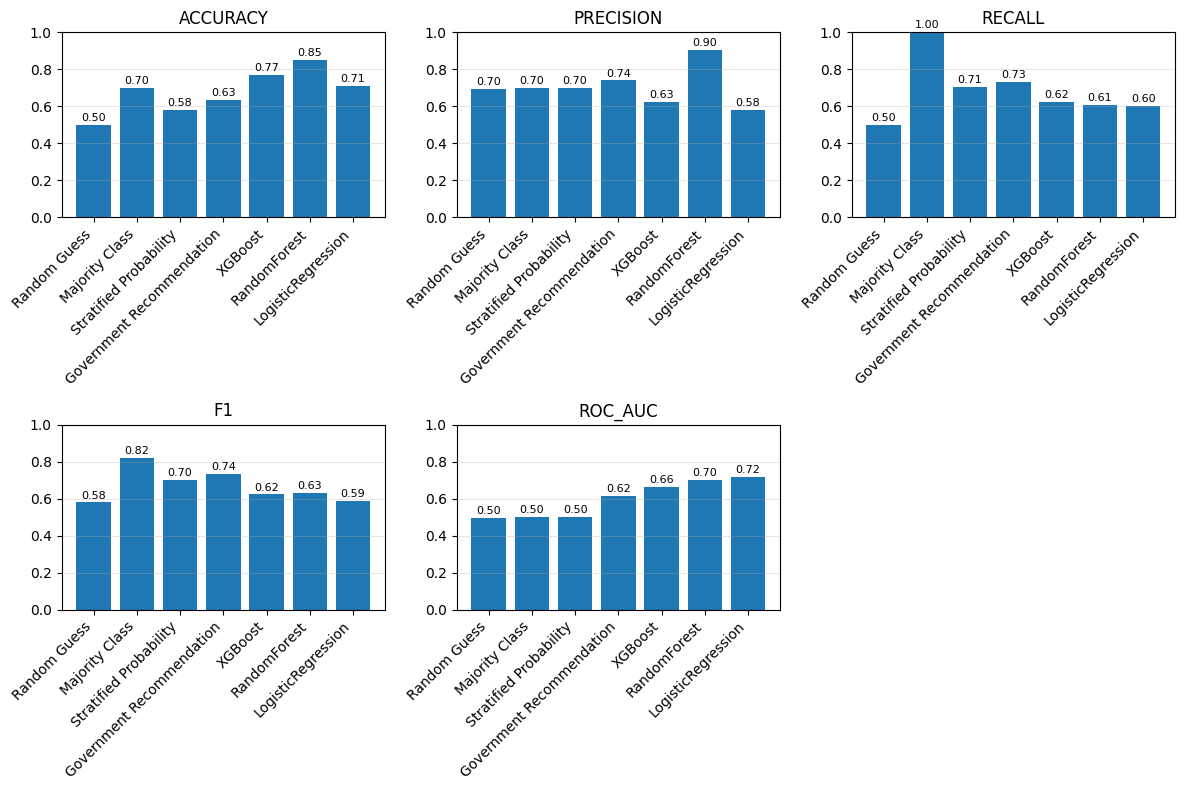

In [46]:
# Compare the global prediction baseline models
print("\nComparing Global Prediction Baselines:")


# Reorder columns
cols = ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results_df = results_df[cols]

print(results_df)

# Visualize the results
plt.figure(figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
models = results_df['model'].tolist()

# Para garantir que todos os modelos estejam presentes nos gráficos, mesmo se algum valor for None,
# vamos substituir None por np.nan e plotar todos os modelos, deixando barras vazias para valores ausentes.
import numpy as np

for metric in metrics:
    results_df[metric] = results_df[metric].apply(lambda x: np.nan if x is None else x)

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    values = results_df[metric].values
    plt.bar(models, values)
    plt.title(f'{metric.upper()}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    # Opcional: mostrar valor na barra, mesmo se for nan
    for idx, val in enumerate(values):
        if not np.isnan(val):
            plt.text(idx, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [33]:
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,Random Guess,0.497696,0.695152,0.498789,0.580823,0.495761
1,Majority Class,0.697696,0.697696,1.000000,0.821933,0.500000
2,Stratified Probability,0.582258,0.698421,0.706187,0.702283,0.501489
3,Government Recommendation,0.634255,0.739951,0.733598,0.736761,0.616754
4,XGBoost,0.706144,0.588081,0.604082,0.592764,0.640515
5,RandomForest,0.783717,0.631161,0.560090,0.563878,0.576885
6,LogisticRegression,0.655914,0.574055,0.602090,0.571459,0.745606
